In [4]:
%load_ext autoreload
from PFMD import DiscretePeierls
from matplotlib import pyplot as plt
import jax.numpy as jnp
import numpy as np
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import MultipleLocator
import json
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
b = 1.0                # 单位: b (基本长度单位)
a = jnp.sqrt(2) * b / 2  # 根据b计算a，单位: b
nu = 0.297039 
κs= 1.0           # 螺旋位错相关刚度
κe= 124.446 / 72.732  # 刃型位错相关刚度
βs = 0.5 * jnp.sqrt(3) / 4  # 螺旋位错非线性项系数 (单位: 0.5*μ*λ)
βe = jnp.sqrt(3) / 4        # 刃型位错非线性项系数 (单位: μ*λ)
λ= jnp.sqrt(3) / 4   #位错线之间的间距

ωr_se = jnp.array([βs, βe]) / λ**2  # 弹性系数项，形状 (2,)
ωs_se = jnp.array([κs, κe]) / λ     # 非线性系数项，形状 (2,)
c = [  
    -0.0019125519595932596,
    0.0003005935369634915,
    -0.004239113307857148,
    0.000025312895300520926,
    -0.000016013823539506667,
    -0.0007614840227797769,
    0.00020200193876531548,
    -0.000027877026670403876,
    4.032454755765513e-6,
    0.0035967678463422782,
    -0.00695607350257013,
    -0.0004427695369179309,
    2.4014461498135325e-7,
    -0.00014243187185675744,
    -0.000057645719547335114,
    0.01919935925806344
    ]  # gamma面参数

In [6]:
def Gamma(u, gamma_c):
    p = 2*jnp.pi/jnp.sqrt(3)
    q = 2*jnp.pi
    """
    Gamma surface
    """
    term = gamma_c[15] 
    
    term += gamma_c[0] * (
        jnp.cos(2.0 * p * u[1]) + 
        jnp.cos(1.0 * p * u[1] + 1.0 * q * u[0]) + 
        jnp.cos(1.0 * p * u[1] - 1.0 * q * u[0])
    )
    term += gamma_c[1] * (
        jnp.cos(2.0 * q * u[0]) + 
        jnp.cos(3.0 * p * u[1] + 1.0 * q * u[0]) + 
        jnp.cos(3.0 * p * u[1] - 1.0 * q * u[0])
    ) 
    term += gamma_c[2] * (
        jnp.cos(4.0 * p * u[1]) + 
        jnp.cos(2.0 * p * u[1] + 2.0 * q * u[0]) + 
        jnp.cos(2.0 * p * u[1] - 2.0 * q * u[0])
    )
    term += gamma_c[3] * (
        jnp.cos(5.0 * p * u[1] + 1.0 * q * u[0]) + 
        jnp.cos(4.0 * p * u[1] + 2.0 * q * u[0]) + 
        jnp.cos(1.0 * p * u[1] + 3.0 * q * u[0]) + 
        jnp.cos(1.0 * p * u[1] - 3.0 * q * u[0]) + 
        jnp.cos(4.0 * p * u[1] - 2.0 * q * u[0]) + 
        jnp.cos(5.0 * p * u[1] - 1.0 * q * u[0])
    )  
    term += gamma_c[4] * (
        jnp.cos(6.0 * p * u[1]) + 
        jnp.cos(3.0 * p * u[1] + 3.0 * q * u[0]) + 
        jnp.cos(3.0 * p * u[1] - 3.0 * q * u[0])
    )
    term += gamma_c[5] * (
        jnp.cos(4.0 * q * u[0]) + 
        jnp.cos(6.0 * p * u[1] + 2.0 * q * u[0]) + 
        jnp.cos(6.0 * p * u[1] - 2.0 * q * u[0])
    )
    term += gamma_c[6] * (
        jnp.cos(8.0 * p * u[1]) + 
        jnp.cos(4.0 * p * u[1] + 4.0 * q * u[0]) + 
        jnp.cos(4.0 * p * u[1] - 4.0 * q * u[0])
    )
    term += gamma_c[7] * (
        jnp.cos(6.0 * q * u[0]) + 
        jnp.cos(9.0 * p * u[1] + 3.0 * q * u[0]) + 
        jnp.cos(9.0 * p * u[1] - 3.0 * q * u[0])
    )
    term += gamma_c[8] * (
        jnp.cos(10.0 * p * u[1]) + 
        jnp.cos(5.0 * p * u[1] + 5.0 * q * u[0]) + 
        jnp.cos(5.0 * p * u[1] - 5.0 * q * u[0])
    )
    term += gamma_c[9] * (
        jnp.sin(2.0 * p * u[1]) - 
        jnp.sin(1.0 * p * u[1] + 1.0 * q * u[0]) - 
        jnp.sin(1.0 * p * u[1] - 1.0 * q * u[0])
    )
    term += gamma_c[10] * (
        jnp.sin(4.0 * p * u[1]) - 
        jnp.sin(2.0 * p * u[1] + 2.0 * q * u[0]) - 
        jnp.sin(2.0 * p * u[1] - 2.0 * q * u[0])
    )
    term += gamma_c[11] * (
        jnp.sin(5.0 * p * u[1] + 1.0 * q * u[0]) - 
        jnp.sin(4.0 * p * u[1] + 2.0 * q * u[0]) - 
        jnp.sin(1.0 * p * u[1] + 3.0 * q * u[0]) - 
        jnp.sin(1.0 * p * u[1] - 3.0 * q * u[0]) - 
        jnp.sin(4.0 * p * u[1] - 2.0 * q * u[0]) + 
        jnp.sin(5.0 * p * u[1] - 1.0 * q * u[0])
    )
    term += gamma_c[12] * (
        jnp.sin(6.0 * p * u[1]) - 
        jnp.sin(3.0 * p * u[1] + 3.0 * q * u[0]) - 
        jnp.sin(3.0 * p * u[1] - 3.0 * q * u[0])
    )
    term += gamma_c[13] * (
        jnp.sin(8.0 * p * u[1]) - 
        jnp.sin(4.0 * p * u[1] + 4.0 * q * u[0]) - 
        jnp.sin(4.0 * p * u[1] - 4.0 * q * u[0])
    )
    term += gamma_c[14] * (
        jnp.sin(10.0 * p * u[1]) - 
        jnp.sin(5.0 * p * u[1] + 5.0 * q * u[0]) - 
        jnp.sin(5.0 * p * u[1] - 5.0 * q * u[0])
    )
    return term

In [10]:
nl = 100
lspan = jnp.arange(-nl//2, nl//2)
# part1 = (np.arctan(lspan + 3.5)/(2*np.pi))+(np.arctan(lspan - 3.5)/(2*np.pi))+0.5

# # 拼接零数组
# u_init = np.concatenate([part1, np.zeros(nl)])  # 形状 (2*NL,)
uzinit = jnp.arctan(lspan + 3.5 )/(2*jnp.pi)+ jnp.arctan(lspan - 3.5 )/(2*jnp.pi) +0.5
u_init = jnp.c_[uzinit, jnp.zeros(nl)]
# 初始化存储数组
sumuz = []
for sigma_x in range(0,3,1):
    params_test = {
     'omega_r': (ωr_se[0], ωr_se[1]),
     'omega_s': (ωs_se[0], ωs_se[1]),
     'uz_bound': (0.0, 1.0),
     'uy_bound': (0.0, 0.0),
     'sigma': (sigma_x * 1e-4, 0.0),
     'gamma': λ / 2
     }
    peierls = DiscretePeierls(u_init, Gamma, c, params_test)
    t_eval = jnp.linspace(0, 100, 11) 
    t_result, u_result = peierls.run(t_eval)
    # 输出结果
    print("Time points:", t_result)
    print("Solution shape:", u_result.shape)  # (nl, 2, time)
    workdir="./data/"
    filename = os.path.join(workdir, f"output_sigma_x_{sigma_x:02d}.dat")
    np.savetxt(filename, u_result.reshape(-1, 2), fmt="%.6f")
    # 提取最后一个时间步（索引-1或10）的第一个变量（索引0）的和
    sum_uz = np.sum(u_result[-1, :, 0])  # 或 u_result[10, :, 0]
    # 将 sigma_x 和 sum_u 存入 sumuz
    sumuz.append([sigma_x * 1e-4, sum_uz])
    print(f"sigma_x={sigma_x * 1e-4} : sum_u = {sum_uz:.6f}")
    # 将列表转为 NumPy 数组
    #保存 sumuz 到文件
np.savetxt(os.path.join(workdir, "sumuz.dat"), sumuz, fmt="%.6f")
print("sumuz 数组已保存！")
sumuz = np.array(sumuz)

Time points: [  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
Solution shape: (11, 100, 2)
sigma_x=0.0 : sum_u = 49.504715
Time points: [  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
Solution shape: (11, 100, 2)
sigma_x=0.0001 : sum_u = 49.614395
Time points: [  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
Solution shape: (11, 100, 2)
sigma_x=0.0002 : sum_u = 49.763336
sumuz 数组已保存！


In [9]:
sumuz

array([[ 0.        , 49.50471497]])

In [ ]:
np.savetxt("output_text.dat", u_result.reshape(-1, 2), fmt="%.6f")

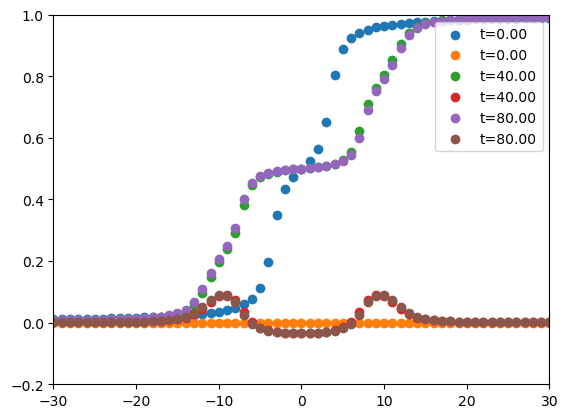

In [58]:
workdir="E:/python/by_deng/DPFMD-main/DPFMD-main/data/"
filename = "output_sigma_x_00.dat"
# 动态拼接路径
file_path = os.path.join(workdir, filename)
# 读取后需恢复原始形状
u_result_load = np.loadtxt(file_path).reshape(11, 100, 2)
for i in range(0,10,4):
    plt.scatter(lspan, u_result_load[i, :, 0], label=f't={t_result[i]:.2f}')
    plt.scatter(lspan, u_result_load[i, :, 1], label=f't={t_result[i]:.2f}')
    plt.xlim(-30, 30)
    plt.ylim(-0.2, 1)
plt.legend()

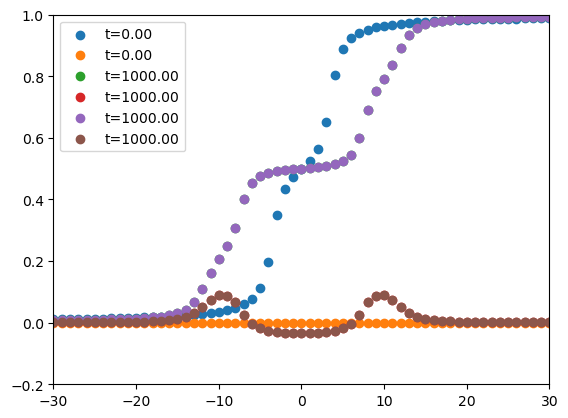

In [38]:
for i in range(0,101,50):
    plt.scatter(lspan, u_result[i, :, 0], label=f't={t_result[i]:.2f}')
    plt.scatter(lspan, u_result[i, :, 1], label=f't={t_result[i]:.2f}')
    plt.xlim(-30, 30)
    plt.ylim(-0.2, 1)
plt.legend()

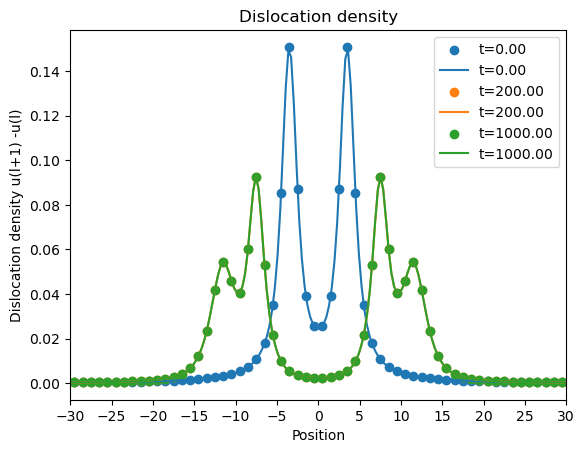

In [15]:
diffs_uz = np.diff(u_result[:, :, 0], axis=1)
x_diff = (lspan[:-1] + lspan[1:]) / 2
# 绘制不同时间步的差值
plt.figure()
for i in [0,2,10]:
    x_smooth = np.linspace(x_diff.min(), x_diff.max(), 300)  # 300个插值点
    spline = make_interp_spline(x_diff, diffs_uz[i, :], k=3)         # 三次样条插值（k=3）
    y_smooth = spline(x_smooth)
    plt.scatter(x_diff, diffs_uz[i, :], label=f't={t_result[i]:.2f}')
    plt.plot(x_smooth, y_smooth, label=f't={t_result[i]:.2f}')  # 平滑曲线
    plt.xlim(-30, 30)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
plt.xlabel('Position')
plt.ylabel('Dislocation density u(l+1) -u(l)')
plt.legend()
plt.title('Dislocation density')
plt.show()

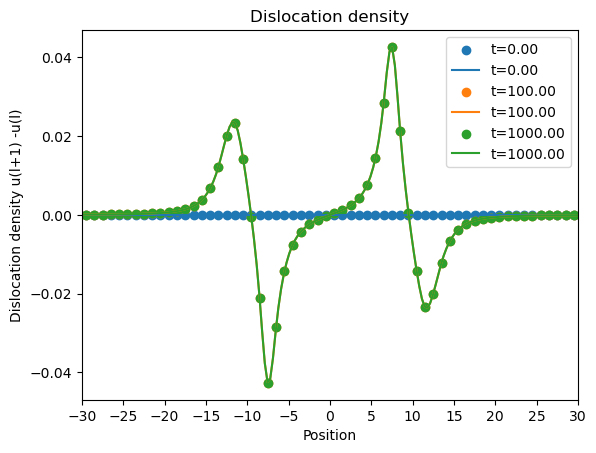

In [18]:
diffs_uy = np.diff(u_result[:, :, 1], axis=1)
x_diff = (lspan[:-1] + lspan[1:]) / 2
# 绘制不同时间步的差值
plt.figure()
for i in [0,1,10]:
    x_smooth = np.linspace(x_diff.min(), x_diff.max(), 300)  # 300个插值点
    spline = make_interp_spline(x_diff, diffs_uy[i, :], k=3)         # 三次样条插值（k=3）
    y_smooth = spline(x_smooth)
    plt.scatter(x_diff, diffs_uy[i, :], label=f't={t_result[i]:.2f}')
    plt.plot(x_smooth, y_smooth, label=f't={t_result[i]:.2f}')  # 平滑曲线
    plt.xlim(-30, 30)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
plt.xlabel('Position')
plt.ylabel('Dislocation density u(l+1) -u(l)')
plt.legend()
plt.title('Dislocation density')
plt.show()